# Notebook to show feature extraction for bigger spatial areas via client-side block processing
In this example we focus on EU-27 and an area in Slovakia. The prepared tiling grid is generated in the wished output CRS EPSG:3035 (LAEA). The tiling (block processing) is happening on client side.
<br><br>
We will demonstrate how to use the openEO `MultiBackendJobManager` to set-up and track multiple jobs at once using OpenEO. <br> <br>
Key features <br>
Job Tracking: Keep track of jobs their statuses and results across different backends. <br>
Error Handling: Customizable handling of job errors and completed jobs. <br>
Database Support: Persist job metadata using CSV or Parquet files, allowing you to resume tracking after interruptions.<br><br>
The error handling in this example is basic - by restarting the script with the same settings the jobmanager will continue with `not_started` jobs.

In [1]:
import openeo
from openeo.extra.job_management import MultiBackendJobManager, CsvJobDatabase
from eo_processing.utils import init_connection, location_visu, laea20km_id_to_extent, reproj_bbox_to_ll
from eo_processing.openeo.processing import generate_master_feature_cube
from eo_processing.config import get_job_options, get_collection_options, get_standard_processing_options
import eo_processing.resources
import importlib.resources as importlib_resources
import geopandas as gpd
import pandas as pd
import os
import matplotlib.pyplot as plt
from shapely import wkt
import time

### specify space and time context

In [2]:
# the time context is given by start and end date
start = '2021-01-01'
end = '2022-01-01'   # the end is always exclusive

# the space context is defined as a bounding box dictionary with south,west,north,east and crs
# we take as example the AOI of Slovakia Devin_Lake (wetlands)
AOI = {'east': 4838000, 'south': 2818000, 'west': 4831000, 'north': 2825000, 'crs': 'EPSG:3035'}

### intersect the AOI with the tiling grid to specify the block processing extents

In [3]:
# get the LAEA-20km grid saved as EPSG:4326 vector
grid = importlib_resources.files(eo_processing.resources).joinpath('LAEA-20km.gpkg')
gdf = gpd.read_file(os.path.normpath(grid))

# spatial intersect and retrieve the tile_ID's of the LAEA-20km grid (convert AOI to EPSG:4326)
gdf_aoi = gdf[gdf.intersects(reproj_bbox_to_ll(AOI))]

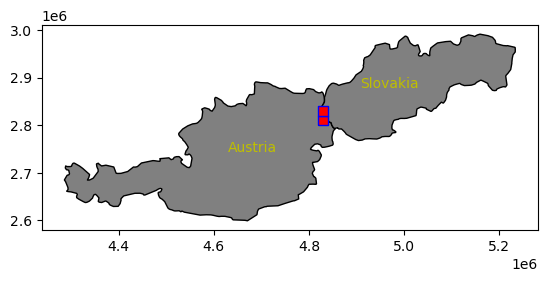

In [4]:
# visualization of the selected tiles in the tiling grid which needs to be processed to cover the AOI
location_visu(gdf_aoi, zoom=True, region='EU', label=True)

### set the root output folder

In [5]:
# define the output folder (make sure you adapt this to your folder structure)
test_num = 10
out_root = os.path.normpath(r'\\netapp03.vgt.vito.be\people_vol1\tests\openeo\eo_processing')
out_root = os.path.join(out_root, f'test_v{str(test_num)}')
os.makedirs(out_root, exist_ok=True)

### integrating the MultiBackendJobManager


#### creating the jobs database
The `MultiBackendJobManager` uses a jobs database to set-up, start and monitor all desired jobs. We are using Pandas/GeoPandas to create a DataFrame storing the job and all parameters which should adapted for each job.

In this example we can directly use the GeoDataFrame of the tiling grid since after the intersection with the AOI is contains only the remaining block extents to process.

In [6]:
jobs_database = gdf_aoi.copy()

# adding variables needed to run the job as columns to the DataFrame and fill them (each job could get individual parameters for handing over to the start_job function
# adding the time domain 
jobs_database['start'] = start
jobs_database['end'] = end

# adding the output file name
jobs_database['file_name'] = jobs_database.apply(lambda row: f'feature_cube_openeo_{row['name']}_v{str(test_num)}.tif', axis=1)

In [7]:
# show the jobs_database before conversion into a JobDatabaseInterface
jobs_database.head()

,name,geometry,start,end,file_name
11432,E482N280,"MULTIPOLYGON (((16.70812 48.10944, 16.73197 48...",2021-01-01,2022-01-01,feature_cube_openeo_E482N280_v10.tif
11433,E482N282,"MULTIPOLYGON (((16.73197 48.28854, 16.75602 48...",2021-01-01,2022-01-01,feature_cube_openeo_E482N282_v10.tif


#### creating the job `start_job` function
The next step is to define a `start_job` function. This function will instruct the `MultiBackendJobManager` on how to initiate a new job on the selected backend. The `start_job` functionality should adhere to the following structure _start_job(row: pd.Series, connection: openeo.Connection, **kwargs)_.

In [8]:
def start_job(row: gpd.GeoSeries, connection: openeo.Connection, provider: str , **kwgs) -> openeo.BatchJob:
    """Start a new job using the specified row out of the jobs GeoDataFrame and connection."""
    
    # Get the variable parameters from the dataframe
    tileID = row["name"]
    start = row["start"]
    end = row["end"]
    file_name = os.path.normpath(row["file_name"])
    
    # get the openEO bbox dictionary for this tileID of processing block
    processing_extent = laea20km_id_to_extent(tileID)
    
    # define job_options, processing_options,  and collection_options
    job_options = get_job_options(provider=provider)
    collection_options = get_collection_options(provider=provider)
    processing_options = get_standard_processing_options(provider=provider, task='feature_generation')
    
    # add this job option to run it on old openEO version for CDSE server side
    #job_options.update({"image-name": "registry.prod.warsaw.openeo.dataspace.copernicus.eu/prod/openeo-geotrellis-kube:20240905-1881"})
        
    # define the progress graph
    data_cube = generate_master_feature_cube(connection,
                                             processing_extent,
                                             start,
                                             end,
                                             **collection_options,
                                             **processing_options)
    
    job = data_cube.create_job(title=os.path.splitext(file_name)[0], 
                               description=f'generation of full feature data cube of EO data for tile {tileID}', 
                               out_format='GTiff', 
                               job_options=job_options,
                               filename_prefix=os.path.splitext(file_name)[0]
                               )
    return job

#### run the jobs
With our jobs database and job definition set up, we can now run the jobs using the `MultiBackendJobManager`. This involves defining a path to where we will store the job tracker which contains the job statuses and metadata.
<br> <br>
Note: If the specified job tracker path, points to an existing jobs database (either a .csv or .parquet file), that file will be used as the job tracker, and the input jobs database will be disregarded.

In [9]:
# generate a unique name for the job tracker database (here: CSV file)
job_tracker = os.path.normpath(os.path.join(out_root, 'job_tracker.csv'))

In [10]:
# init of MultiBackendJobManager
manager = MultiBackendJobManager(root_dir=os.path.normpath(out_root), poll_sleep=30)

In [11]:
# create a connection to backend and add this active backend to the jobmanager
backend = 'cdse'  # also possible: terrascope, development, creodias, sentinelhub
connection = init_connection(backend)
manager.add_backend(backend, connection=connection, parallel_jobs=6)

Authenticated using refresh token.


In [ ]:
# run the jobs stand-alone which blocks further usage of the Notebook up to all jobs are done
#manager.run_jobs(df=jobs_database, start_job=start_job, job_db=job_tracker)

In [12]:
# better option in a Notebook is to use an extra thread to run the jobs and keep the notebook active
# for that we have to convert our jobs_database into a JobDatabaseInterface which is saved in the job_tracker location
# Note: we make sure if the job tracker database is already existing that this one is used and continue the processing
job_db = CsvJobDatabase(path=job_tracker)
if job_db.exists():
    print(f"Resuming `run_jobs` from existing {job_db}")
else:
    df = manager._normalize_df(jobs_database)
    job_db.persist(df)
manager.start_job_thread(start_job=start_job, job_db=job_db)

#### small dashboard to see the status
Since the updates of the jobs are stored in the job tracker database on disk, we develop a small graphical interface to keep track of the job status. Moreover, this interface makes sure to stop the job thread when all jobs are done. <br><br>
Note: job status like `start_failed, skipped, error or canceled` are ignored in the check to stop the thread. To reprocess these jobs (tiles) reset the status to `not_started'.


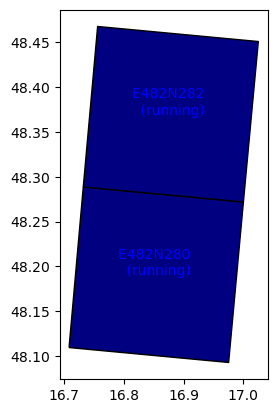

In [ ]:
# visualize the results - first prototype -> improve and maybe integrate in MultiBackendJobManager
while not manager._stop_thread:
    try:
        # create a GEoPandas Dataframe out of the job tracker database (for that the database needs a geometrie column)
        status_df = pd.read_csv(os.path.normpath(job_tracker))
        status_df['geometry'] = status_df['geometry'].apply(wkt.loads)
        status_df = gpd.GeoDataFrame(status_df, crs='epsg:4326')
        
        # updating the colors for processing status
        color_dict = {"not_started": 'grey', 
                      "created": 'gold', 
                      "queued": 'lightsteelblue', 
                      "running": 'navy', 
                      "start_failed": 'salmon', 
                      "skipped": 'darkorange', 
                      "finished": 'lime', 
                      "error": 'darkred', 
                      "canceled": 'magenta'}
        status_df['color'] = status_df['status'].map(color_dict)
        
        # plot the tiles with their status color
        fig, ax = plt.subplots()
        status_df.plot(ax=ax, edgecolor='black', color=status_df['color'])
        
        # add labels to the tiles showing the tileID and status
        status_df['coords'] = status_df['geometry'].apply(lambda x: x.representative_point().coords[:])
        status_df['coords'] = [coords[0] for coords in status_df['coords']]
        for idx, row in status_df.iterrows():
            plt.annotate(text=f'{row['name']} \n ({row['status']})', xy=row['coords'], horizontalalignment='center', color='b')
        
        # show the figure
        plt.show()
        
        # check the conditions to stop the job thread
        filtered = status_df[status_df.status.isin(["not_started", "created", "queued", "running"])]
        if filtered.empty:
            manager.stop_job_thread()
    
        # wait 15 sec and then delete the figure so that it can get recreated
        # we bring that in the end so that the figure is not deleted when all jobs are done or all error
        time.sleep(15)
        if not manager._stop_thread:
            display(fig, clear=True)
    except KeyboardInterrupt:
        break